In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
# load training data
train = pd.read_csv('/Users/zanemotiwala/Documents/jupyter-notebooks/Logistic-Regression-Titanic/titanic-train.csv')
print(train.shape)
train.head()

(891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
# load test data
test = pd.read_csv('/Users/zanemotiwala/Documents/jupyter-notebooks/Logistic-Regression-Titanic/titanic-test.csv')
print(test.shape)
test.head()

(418, 11)


PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

<Axes: xlabel='Survived', ylabel='count'>

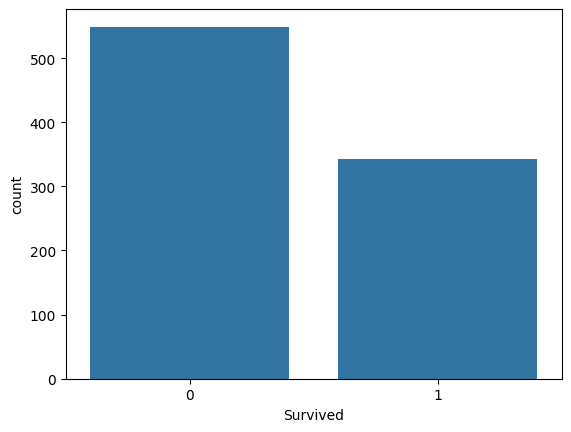

In [4]:
sns.countplot(x = 'Survived',data = train)

<Axes: xlabel='Survived', ylabel='count'>

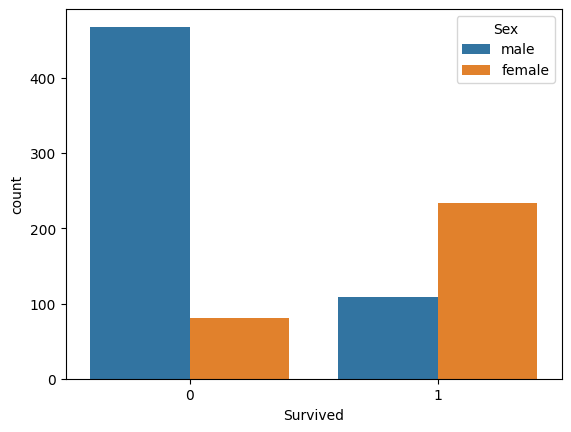

In [5]:
sns.countplot(x = 'Survived',hue = 'Sex',data = train)

<Axes: xlabel='Survived', ylabel='count'>

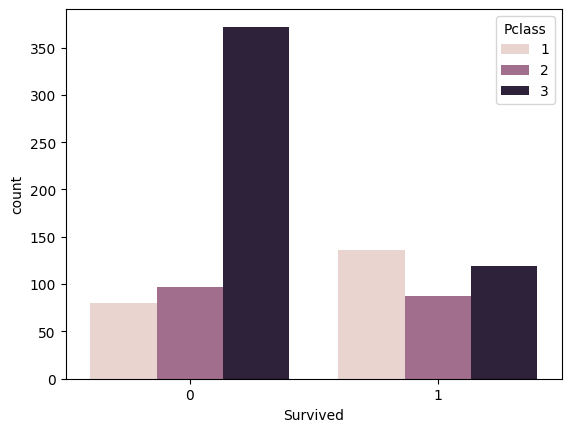

In [6]:
sns.countplot(x = 'Survived',hue = 'Pclass',data = train)

In [7]:
# add family columns
train["Family"] = train['SibSp']+train['Parch']
train.drop(['SibSp','Parch'],inplace=True,axis=1)
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  \
0                            Braund, Mr. Owen Harris    male  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2                             Heikkinen, Miss. Laina  female  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4                           Allen, Mr. William Henry    male  35.0   

             Ticket     Fare Cabin Embarked  Family  
0         A/5 21171   7.2500   NaN        S       1  
1          PC 17599  71.2833   C85        C       1  
2  STON/O2. 3101282   7.9250   NaN        S       0  
3            113803  53.1000  C123        S       1  
4            373450   8.0500   NaN        S       0

In [8]:
test["Family"] = test['SibSp']+test['Parch']
test.drop(['SibSp','Parch'],inplace=True,axis=1)
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age   Ticket     Fare Cabin Embarked  Family  
0  34.5   330911   7.8292   NaN        Q       0  
1  47.0   363272   7.0000   NaN        S       1  
2  62.0   240276   9.6875   NaN        Q       0  
3  27.0   315154   8.6625   NaN        S       0  
4  22.0  3101298  12.2875   NaN        S       2

<Axes: xlabel='Age_categories'>

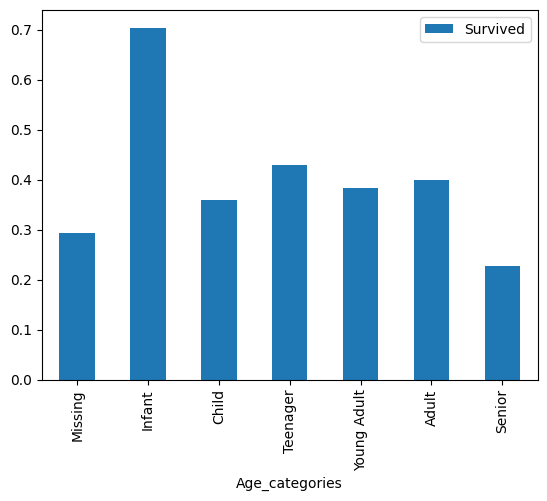

In [9]:
# bucket the age columns since it is continuous
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()

In [10]:
# one hot encode categorical cols
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories",'Embarked']:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

In [11]:
#remove those with too many categories or categorical
train.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)
test.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)

In [12]:
train.head()


PassengerId  Survived   Age     Fare Cabin  Family  Pclass_1  Pclass_2  \
0            1         0  22.0   7.2500   NaN       1     False     False   
1            2         1  38.0  71.2833   C85       1      True     False   
2            3         1  26.0   7.9250   NaN       0     False     False   
3            4         1  35.0  53.1000  C123       1      True     False   
4            5         0  35.0   8.0500   NaN       0     False     False   

   Pclass_3  Sex_female  ...  Age_categories_Missing  Age_categories_Infant  \
0      True       False  ...                   False                  False   
1     False        True  ...                   False                  False   
2      True        True  ...                   False                  False   
3     False        True  ...                   False                  False   
4      True       False  ...                   False                  False   

   Age_categories_Child  Age_categories_Teenager  Age_categories_Young Adult  \
0                 False                    False                        True   
1                 False                    False                       False   
2                 False                    False                        True   
3                 False                    False                        True   
4                 False                    False                        True   

   Age_categories_Adult  Age_categories_Senior  Embarked_C  Embarked_Q  \
0                 False                  False       False       False   
1                  True                  False        True       False   
2                 False                  False       False       False   
3                 False                  False       False       False   
4                 False                  False       False       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  

[5 rows x 21 columns]

In [14]:
# instead run on train and test splitsX = train[columns]
X = train[['PassengerId', 'Age', 'Fare','Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']]
y = train['Survived']

train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.20,random_state=0)

In [15]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_X, train_y)
predictions = lr.predict(val_X)
accuracy = accuracy_score(val_y, predictions)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(val_y,predictions))

0.8044692737430168
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [16]:
lr = LogisticRegression(max_iter=10000)
scores = cross_val_score(lr, X, y, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print()
print(accuracy)

[0.76404494 0.7752809  0.7752809  0.79775281 0.82022472 0.82022472
 0.82222222 0.83146067 0.83146067 0.86516854]

0.8103121098626715
